In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from scipy.io import *

import copy

In [2]:
def train_decisionStump(X, Y, weightsT):

    stump = DecisionTreeClassifier(criterion='gini', max_depth=1)
    
    stump.fit(X, Y, sample_weight = np.squeeze(weightsT))

    return stump

In [3]:
def compute_weakmodel_coefficient(Y, y, weightsT):
    
    correct = y==Y        
    
    # we invert the vector, becasue we want to find 0-1 loss, where 1 corresponds to incorrect classification
    J = np.invert(correct)
    J = np.expand_dims(J, axis=1)           #shape of J : mx1
    
    error = weightsT.T @ J

    # we use the error computed to find the alpha for the current model t
    alpha = (1/2) * np.log((1-error)/(error + np.finfo(float).eps) )
    
    return alpha

In [4]:
def update_ensemble(adaboost_model, stumpt, alpha):
    
    adaboost_model['alphas'].append(alpha)
    adaboost_model['stumps'].append(stumpt) 
    
    return adaboost_model

In [5]:
def update_trainingsamples_weights(Y, y, alpha, weightsT):
    
    # if prediction is correct, sample weight decreases
    # if prediction is incorrect, sample weight increases
    
    significance = alpha * Y * y

    # updating the weights
    weightsT = weightsT * np.exp(-significance).T

    # normalziing the weights
    Z = np.sum(weightsT)
    weightsT = weightsT/(Z+ np.finfo(float).eps)
    
    return weightsT

In [6]:
def AdaBoostClassifier_train(X_train, Y_train, T):
    
    # Step: 1
    # Initialize the weights
    # Initially all are given equal weights
    m = X_train.shape[0]
    weightsT = np.ones((m,1))/m
    
    # Ensemble model
    adaboost_model = { 'alphas':[], 'stumps':[] }
    model_log = { 'adaboost_model':[], 'T':[] }
    
    #classes converted to -1 and 1 to ease implementation
    Y_train = Y_train.copy() 
    Y_train[Y_train==0] = -1
    
    tic = time.time()
    
    for t in range(T):
        
        # Step: 2
        # Train the weak model
        stumpt = train_decisionStump(X_train, Y_train, weightsT)

        # Step: 3
        # Use the trained weak model t to make predictions on the whole dataset 
        # and then based on its performance compute its coefficient
        y = stumpt.predict(X_train)
        alpha = compute_weakmodel_coefficient(Y_train, y, weightsT)
        
        # Step: 4
        # Update ensemble model with this weak model t
        adaboost_model = update_ensemble(adaboost_model, stumpt, alpha)
        
        # Step: 5
        # Update weights of training samples 
        weightsT = update_trainingsamples_weights(Y_train, y, alpha, weightsT)
        
        
        if t%10 == 0:
            yPred,_,h = predict(X_train, adaboost_model)
            yPred[yPred == 0] = -1
            
            J_train_upper = overall_error_upperbound(Y_train, h, t)
            J_train = overall_error(Y_train, yPred)
            
            print("Iteration {} : Train Error = {}, Train Error Upperbound = {}".format(t, 
                                                np.round(J_train, 4), np.round(J_train_upper, 4)))
            
        if t%200 == 0:
            model_log['adaboost_model'].append(copy.deepcopy(adaboost_model))
            model_log['T'].append(t)
               
        
        # Step: 6
        # repeat steps 2 to 5 until the adaboost model is able to generalize well
        # i.e. for T iterations
       
    
    print("\n Training Complete!")
    
    plot_training_error(adaboost_model, X_train, Y_train)
    
    
    # Step: 7
    # return the final Adaboost model
    return adaboost_model, model_log

In [7]:
def display_results(X, y, iteration, adaboost_model):
    """using demo from sklearn AdaBoost """
    
    plot_colors = "br"
    plot_step = 0.02
    class_names = "AB"

    fig = plt.figure(figsize=(15, 5))

    # Plot the decision boundaries
    plt.subplot(131)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))


    Z, _, _ = predict(np.c_[xx.ravel(), yy.ravel()], adaboost_model)

    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")


    # Plot the trainning points
    for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1],
                    c=c, cmap=plt.cm.Paired,
                    s=20, edgecolor='k',
                    label="Class %s" % n)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')


    yPred, confidence, _ = predict(X, adaboost_model)

    
    accuracy, f1 = evaluateClassifier(y, yPred )
        

    # Plot the two-class decision scores
    _, _, twoclass_output = predict(X, adaboost_model)
    twoclass_output = twoclass_output.squeeze()


    plot_range = (twoclass_output.min(), twoclass_output.max())
    plt.subplot(132)
    for i, n, c in zip(range(2), class_names, plot_colors):
        plt.hist(twoclass_output[y == i],
                 bins=10,
                 range=plot_range,
                 facecolor=c,
                 label='Class %s' % n,
                 alpha=.5,
                 edgecolor='k')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, y1, y2 * 1.2))
    plt.legend(loc='upper right')
    plt.ylabel('Samples')
    plt.xlabel('Score')
    plt.title('Decision Scores')

    # Plot the two-class confidence
    plot_range = (confidence.min(), confidence.max())

    plt.subplot(133)
    plt.hist(confidence,
             bins=10,
             range=plot_range,
             facecolor='b',
             alpha=.5,
             edgecolor='k')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, y1, y2 * 1.2))
    plt.ylabel('Samples')
    plt.xlabel('Confidence')
    plt.title('Confidence Distrubution')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35)
    plt.show()
    
    print("Adaboost model for T = {} - Accuracy: {}, F1 score: {}\n\n".format(iteration, 
                                                                              np.round(accuracy,3), 
                                                                              np.round(f1,3)))

In [8]:
def predict(X, adaboost_model):

    h = 0
    T = len(adaboost_model['alphas'])
    
    for t in range(T):
        alpha = adaboost_model['alphas'][t]
        stump = adaboost_model['stumps'][t]
        
        h = h + alpha* stump.predict(X)
    
    confidence = abs(h) / np.sum(abs(np.array(adaboost_model['alphas']).flatten()))
    
    # predictions are returned as 0 and 1
    Z = np.sign(h)
    Z[Z==-1]=0
    
    return Z, confidence.squeeze(), h

In [9]:
def overall_error(Y, y):
    
    m = Y.shape[0]
    
    J = (1/m)*np.sum(y != Y)
    
    return J

In [10]:
def overall_error_upperbound(Y, y, t):
    
    m = Y.shape[0]
    
    temp = 0
    for i in range(m):
        temp = temp + np.exp(-Y[i]*y[0,i])
    
    J = temp/m
    
    return J

In [11]:
def get_errors_over_T(adaboost_model, X, Y):
    
    h = 0
    costs = []
    costs_upper = []
    
    for t in range(T):
        
        alpha = adaboost_model['alphas'][t]
        stump = adaboost_model['stumps'][t]
        
        h = h + alpha* stump.predict(X)
        y = np.sign(h)
    
        J = overall_error(Y, y)
        costs.append(J)
        
        J = overall_error_upperbound(Y, h, t)
        costs_upper.append(J)
    
    return costs, costs_upper

In [12]:
def plot_training_error(adaboost_model, X_train, Y_train):
    
    train_costs, train_costs_upper = get_errors_over_T(adaboost_model, X_train, Y_train)
    
    plt.figure(1)
    plt.rcParams['font.size']=15
    plt.plot(train_costs,'r-')
    plt.xlabel('Number of iterations')
    plt.ylabel('Error')
    plt.legend(['Training error'])
    
    plt.figure(2)
    plt.rcParams['font.size']=15
    plt.plot(train_costs_upper,'r-')
    plt.xlabel('Number of iterations')
    plt.ylabel('Error')
    plt.legend(['Upperbound Training error'])
    
    plt.show()

In [13]:
def evaluateClassifier(Y, y):

    accuracy = np.mean(Y == y)
    f1 = f1_score(Y, y.squeeze())

    return accuracy, f1

### Training:

In [14]:
T = 2000

In [15]:
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)

X = np.concatenate((X1, X2))
y = np.concatenate((y1, 1 - y2))

X, y = shuffle(X, y, random_state=1)

Iteration 0 : Train Error = 0.406, Train Error Upperbound = 0.9822
Iteration 10 : Train Error = 0.198, Train Error Upperbound = 0.7392
Iteration 20 : Train Error = 0.132, Train Error Upperbound = 0.6259
Iteration 30 : Train Error = 0.114, Train Error Upperbound = 0.5604
Iteration 40 : Train Error = 0.122, Train Error Upperbound = 0.5195
Iteration 50 : Train Error = 0.126, Train Error Upperbound = 0.4939
Iteration 60 : Train Error = 0.132, Train Error Upperbound = 0.4772
Iteration 70 : Train Error = 0.13, Train Error Upperbound = 0.4697
Iteration 80 : Train Error = 0.126, Train Error Upperbound = 0.4558
Iteration 90 : Train Error = 0.12, Train Error Upperbound = 0.445
Iteration 100 : Train Error = 0.122, Train Error Upperbound = 0.4377
Iteration 110 : Train Error = 0.122, Train Error Upperbound = 0.4355
Iteration 120 : Train Error = 0.122, Train Error Upperbound = 0.4326
Iteration 130 : Train Error = 0.12, Train Error Upperbound = 0.4284
Iteration 140 : Train Error = 0.12, Train Error U

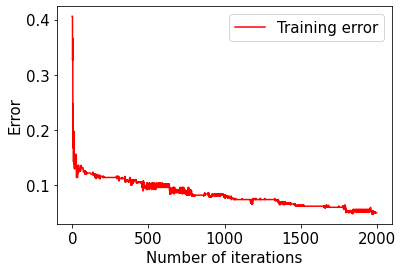

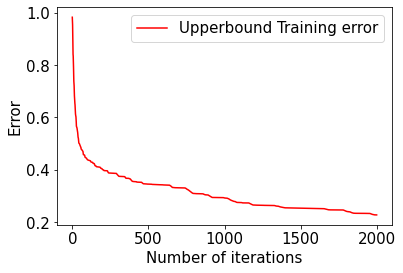

In [16]:
adaboost_model, model_log = AdaBoostClassifier_train(X, y, T)

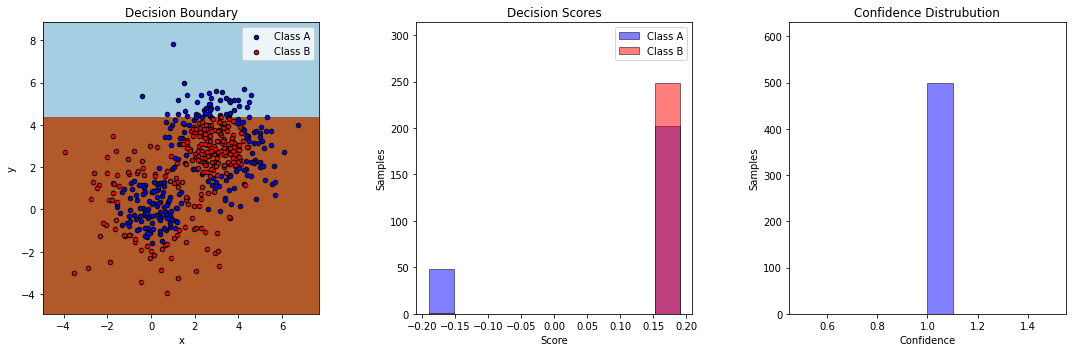

Adaboost model for T = 0 - Accuracy: 0.594, F1 score: 0.71




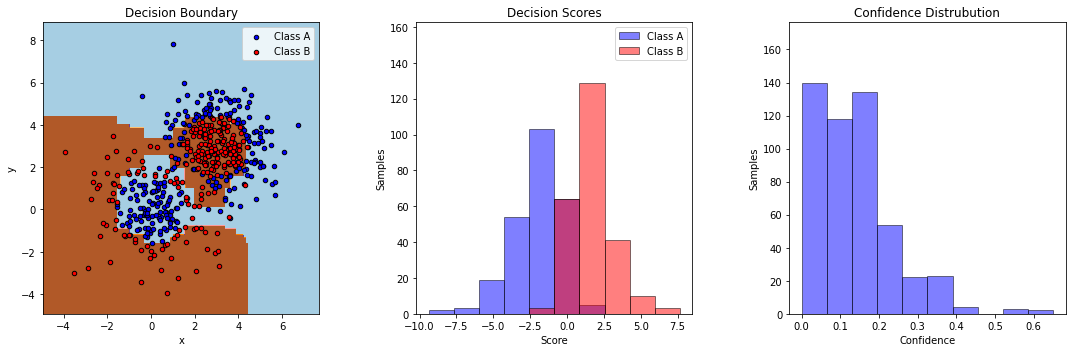

Adaboost model for T = 200 - Accuracy: 0.884, F1 score: 0.885




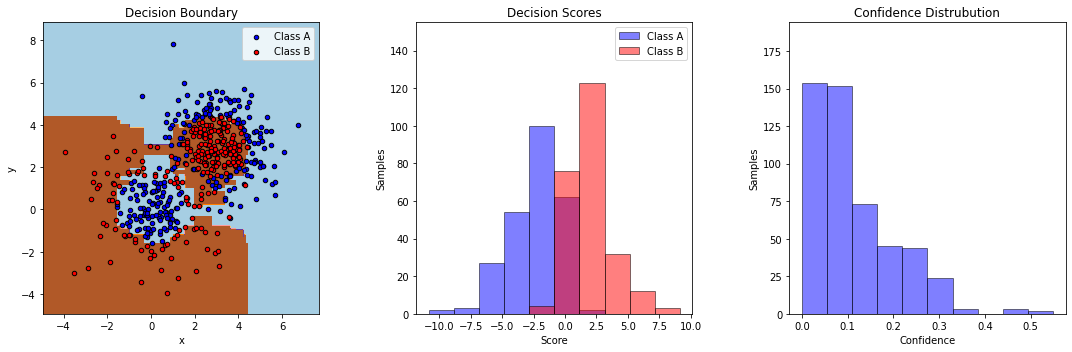

Adaboost model for T = 400 - Accuracy: 0.896, F1 score: 0.896




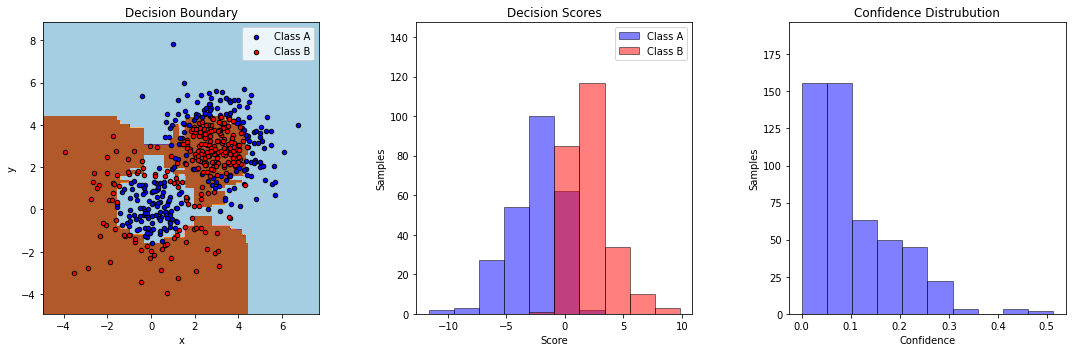

Adaboost model for T = 600 - Accuracy: 0.904, F1 score: 0.904




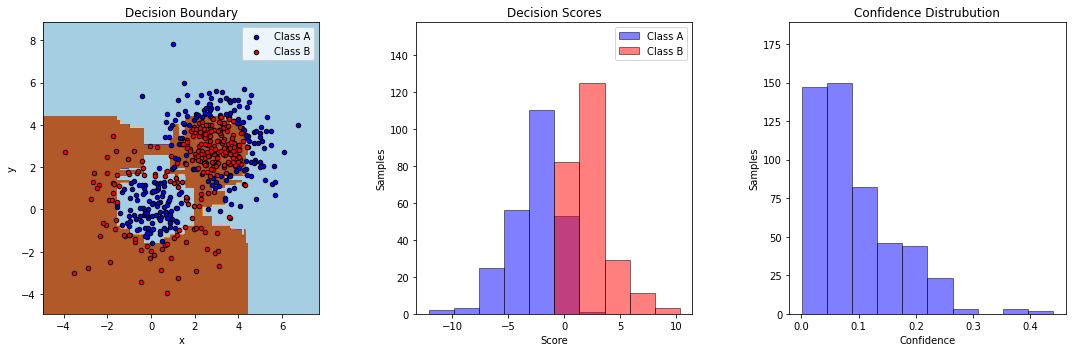

Adaboost model for T = 800 - Accuracy: 0.918, F1 score: 0.918




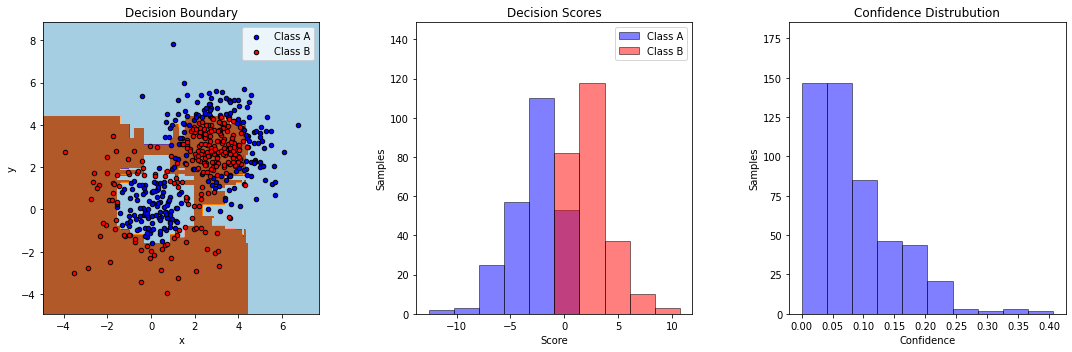

Adaboost model for T = 1000 - Accuracy: 0.918, F1 score: 0.918




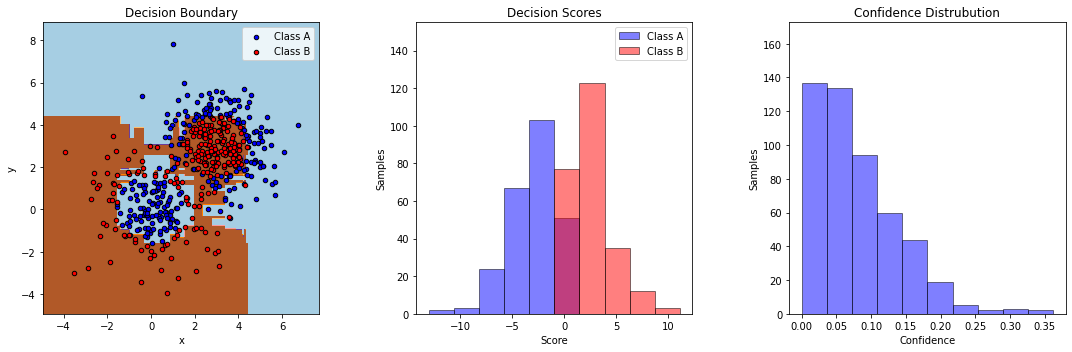

Adaboost model for T = 1200 - Accuracy: 0.926, F1 score: 0.926




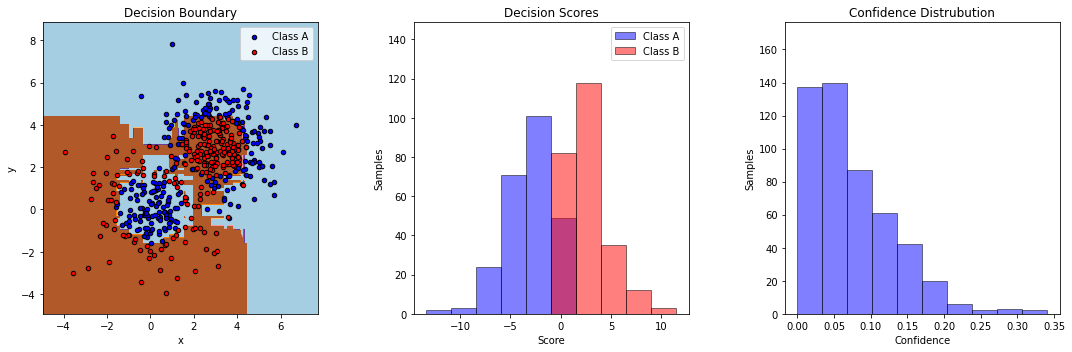

Adaboost model for T = 1400 - Accuracy: 0.934, F1 score: 0.934




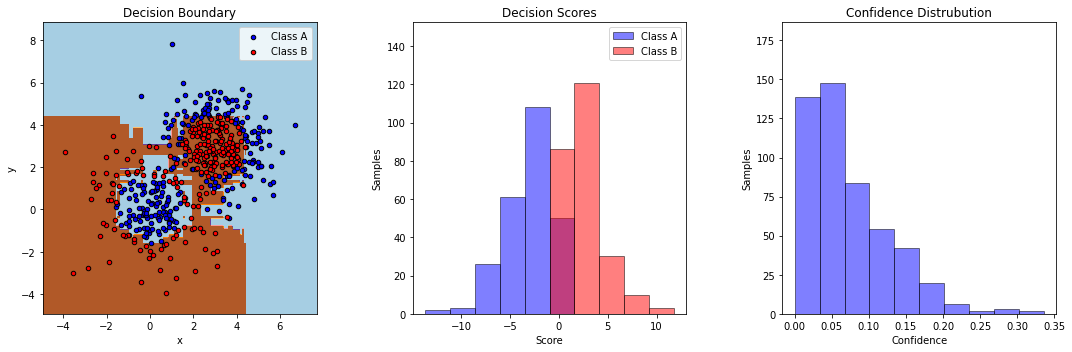

Adaboost model for T = 1600 - Accuracy: 0.938, F1 score: 0.939




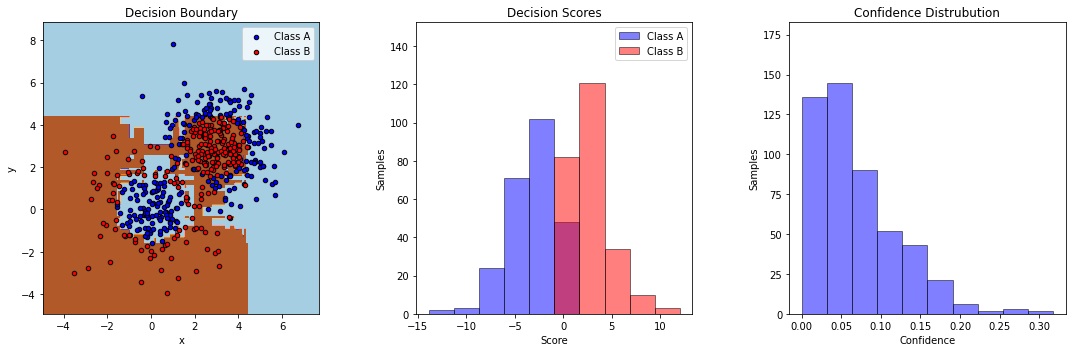

Adaboost model for T = 1800 - Accuracy: 0.944, F1 score: 0.944




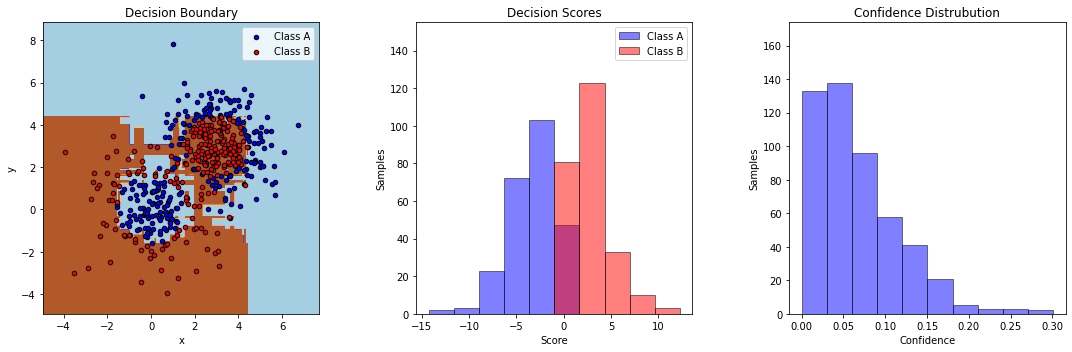

Adaboost model for T = 2000 - Accuracy: 0.95, F1 score: 0.95




In [17]:
%matplotlib inline

for i in range(len(model_log['T'])):

    t = model_log['T'][i]
    model = model_log['adaboost_model'][i]

    display_results(X, y, t, model)
    
display_results(X, y, T, adaboost_model)